In [5]:
from typing import Dict
from pathlib import Path
from text2sql_lib.result_metrics import LLMResultMetrics
from complexity_map import complexity_map
# ---------------------------------------------------------------------------
# create one metrics object per file
# ---------------------------------------------------------------------------
BENCH_DIR           = Path("better_benchmarks")
_SUFFIX             = ".jsonl"                 # all files end with this
metrics: Dict[str, LLMResultMetrics] = {}

for json_file in sorted(BENCH_DIR.glob(f"*{_SUFFIX}")):
    model_name  = json_file.stem                         # e.g. deepseek-r1-14b
    var_name    = model_name.replace("-", "_").replace(".", "_")           # python-valid identifier
    m           = LLMResultMetrics.from_jsonl(
        json_file,
        model_name=model_name,
        complexity_map=complexity_map,
    )
    metrics[var_name] = m
    globals()[var_name] = m     # optional: create variable in global scope

metrics["gpt_4_1"].open_source=False
metrics["gpt_4_1_mini"].open_source=False
metrics["gpt_4_1_nano"].open_source=False
metrics["o3"].open_source=False
metrics["o3"].reasoning=True
metrics["o3_mini"].open_source=False
metrics["o3_mini"].reasoning=True
metrics["o4_mini"].open_source=False
metrics["o4_mini"].reasoning=True
metrics["qwen3_14b"].reasoning=True
metrics["deepseek_r1_14b"].reasoning=True
metrics["qwen3_30b_a3b"].reasoning=True

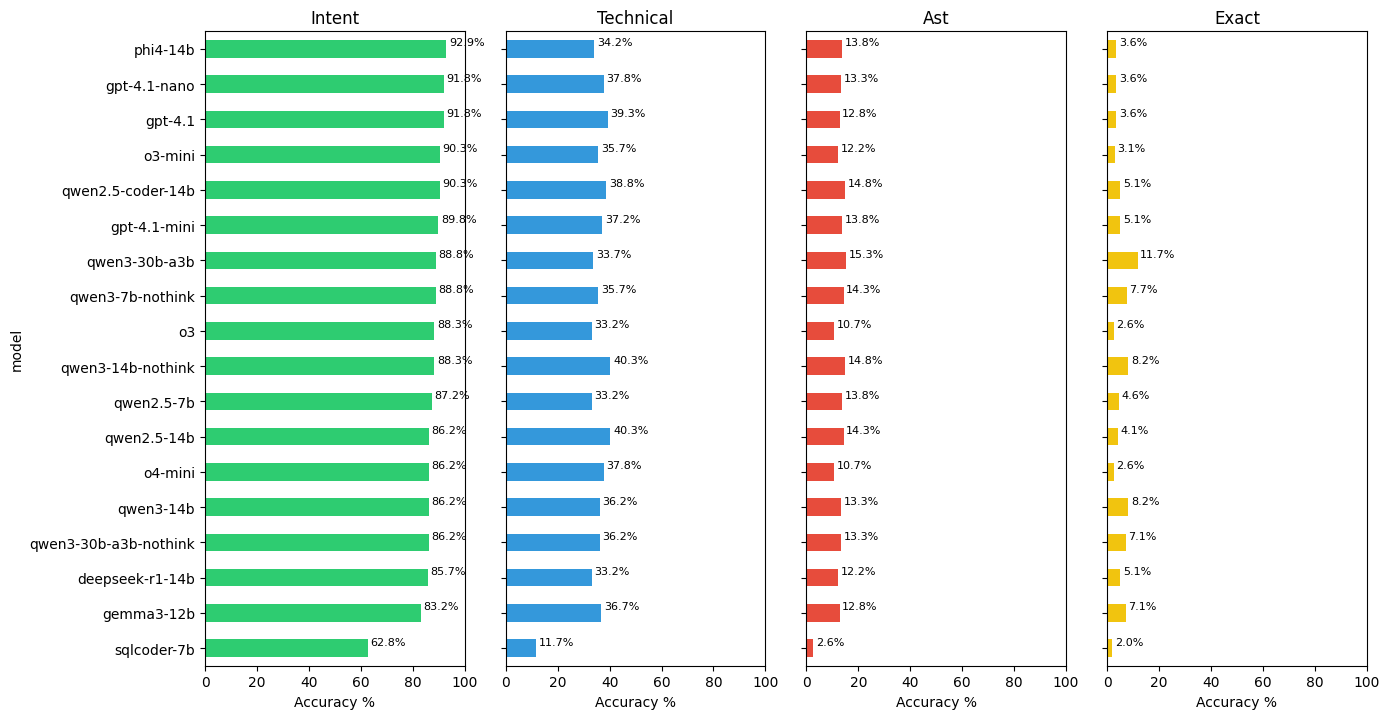

In [9]:
from text2sql_lib.viz_toolbox import *

plot_overall_multi(metrics)

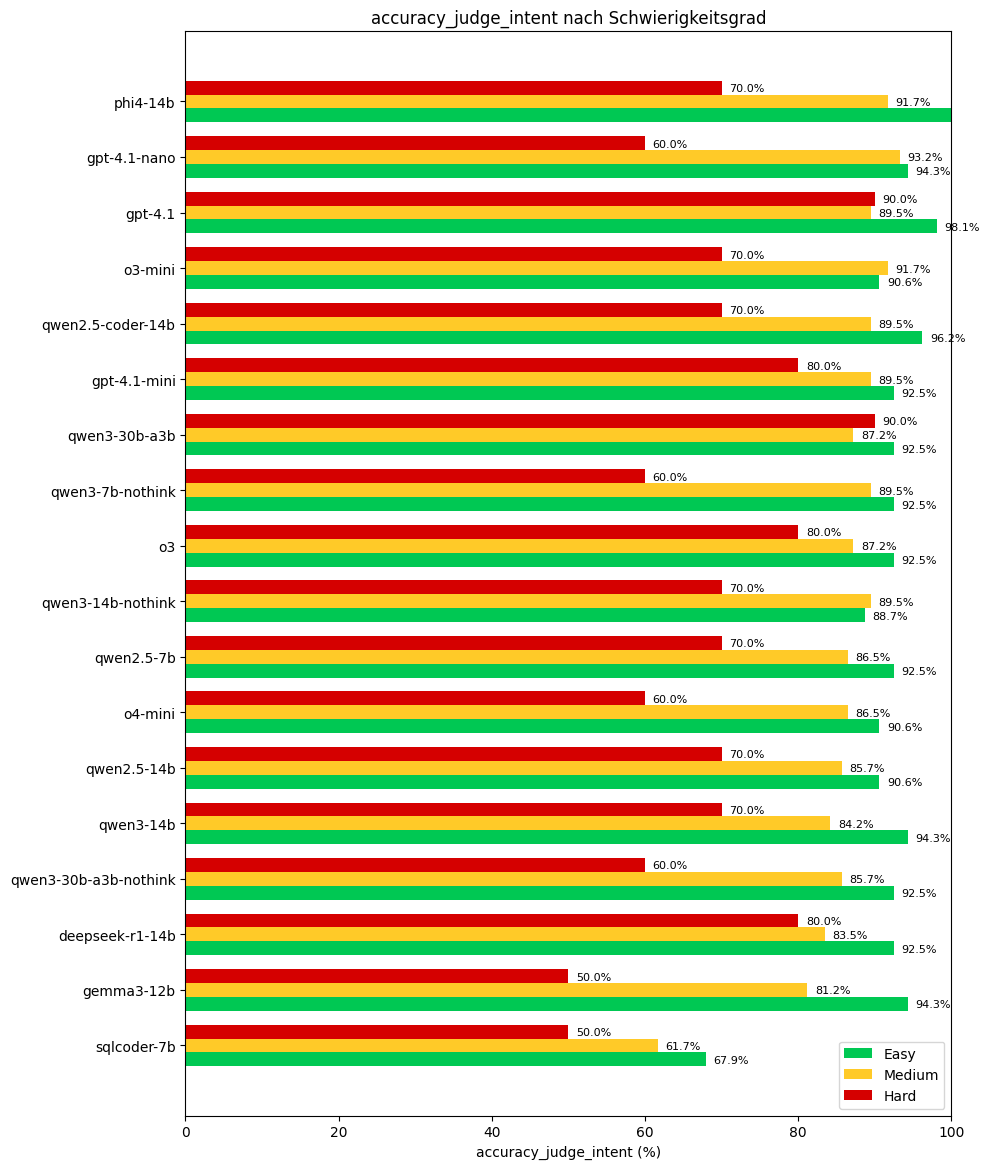

In [10]:
plot_difficulty_grouped(metrics, metric_fn_name="accuracy_judge_intent")

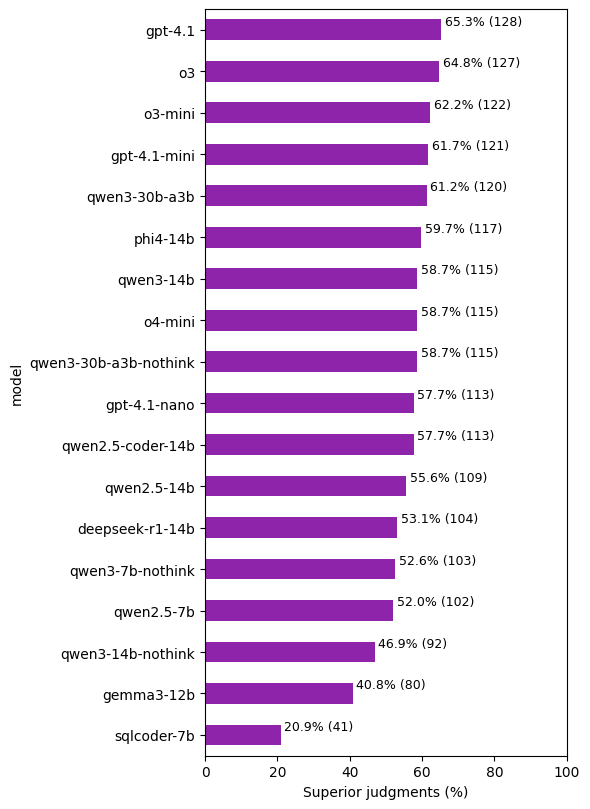

In [11]:
plot_superior(metrics, show_counts=True)

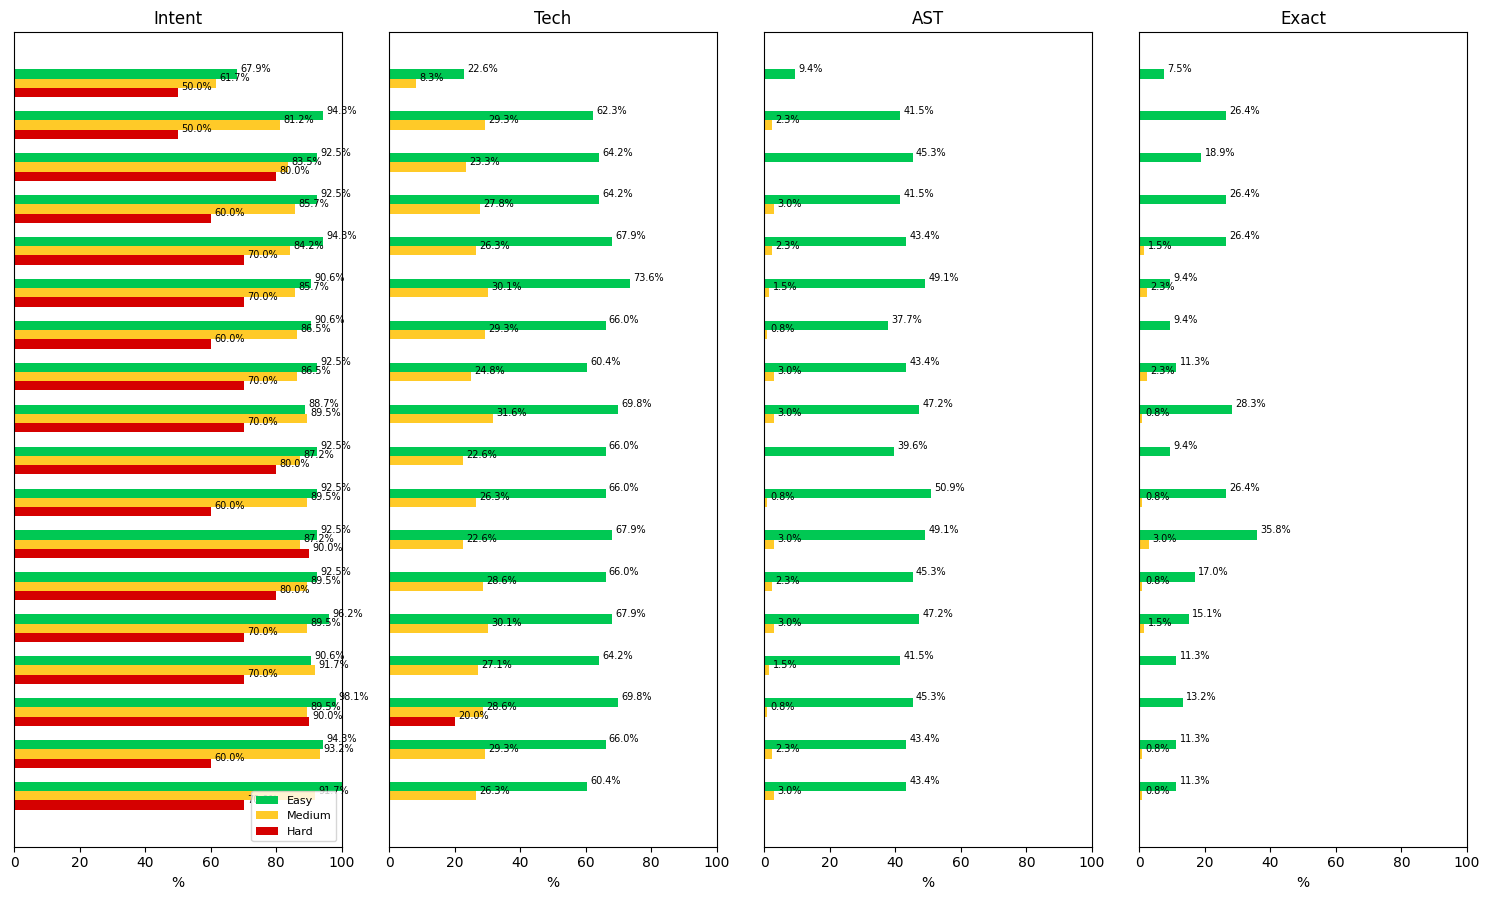

In [12]:
plot_difficulty_multi_metrics(metrics)

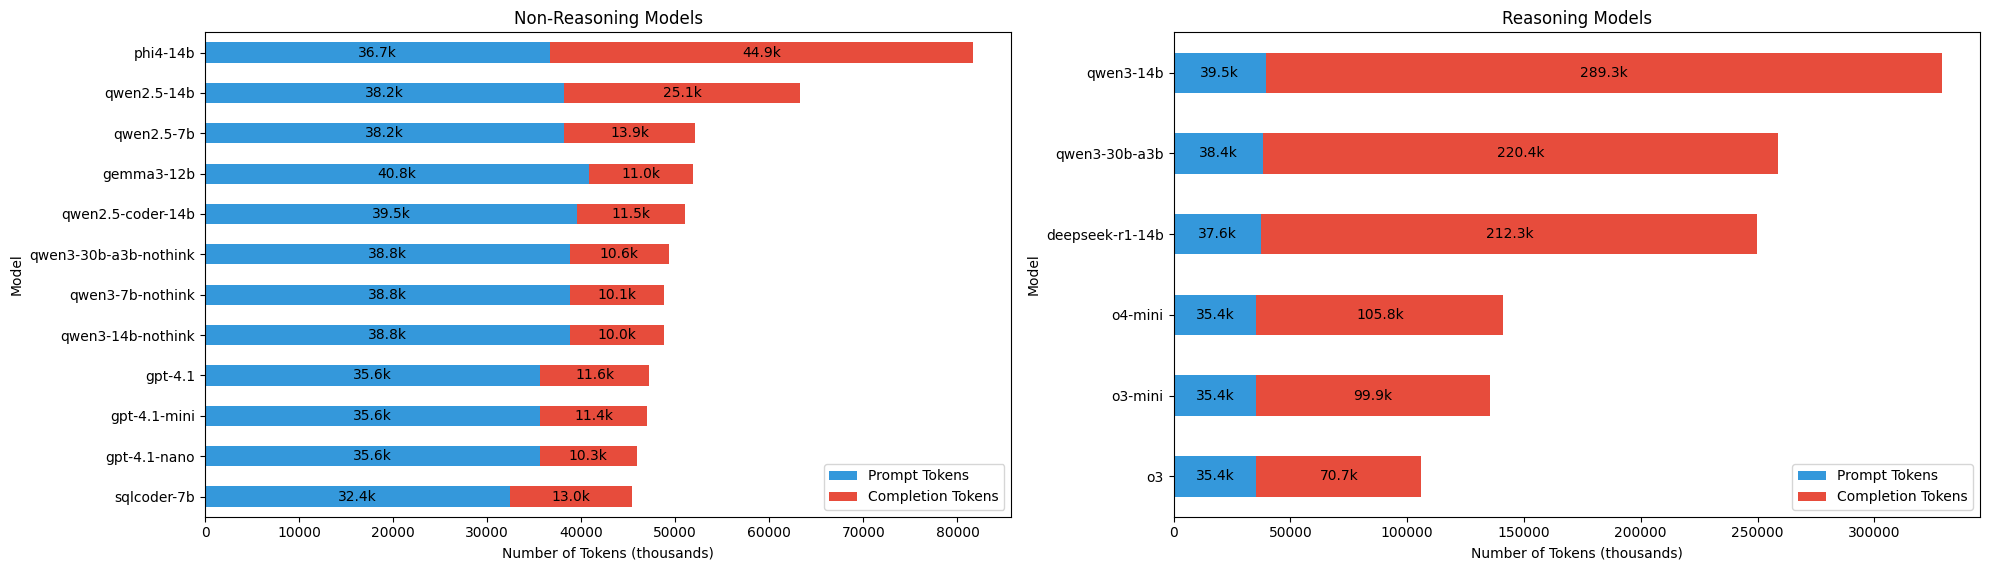

In [13]:
plot_token_usage(metrics)

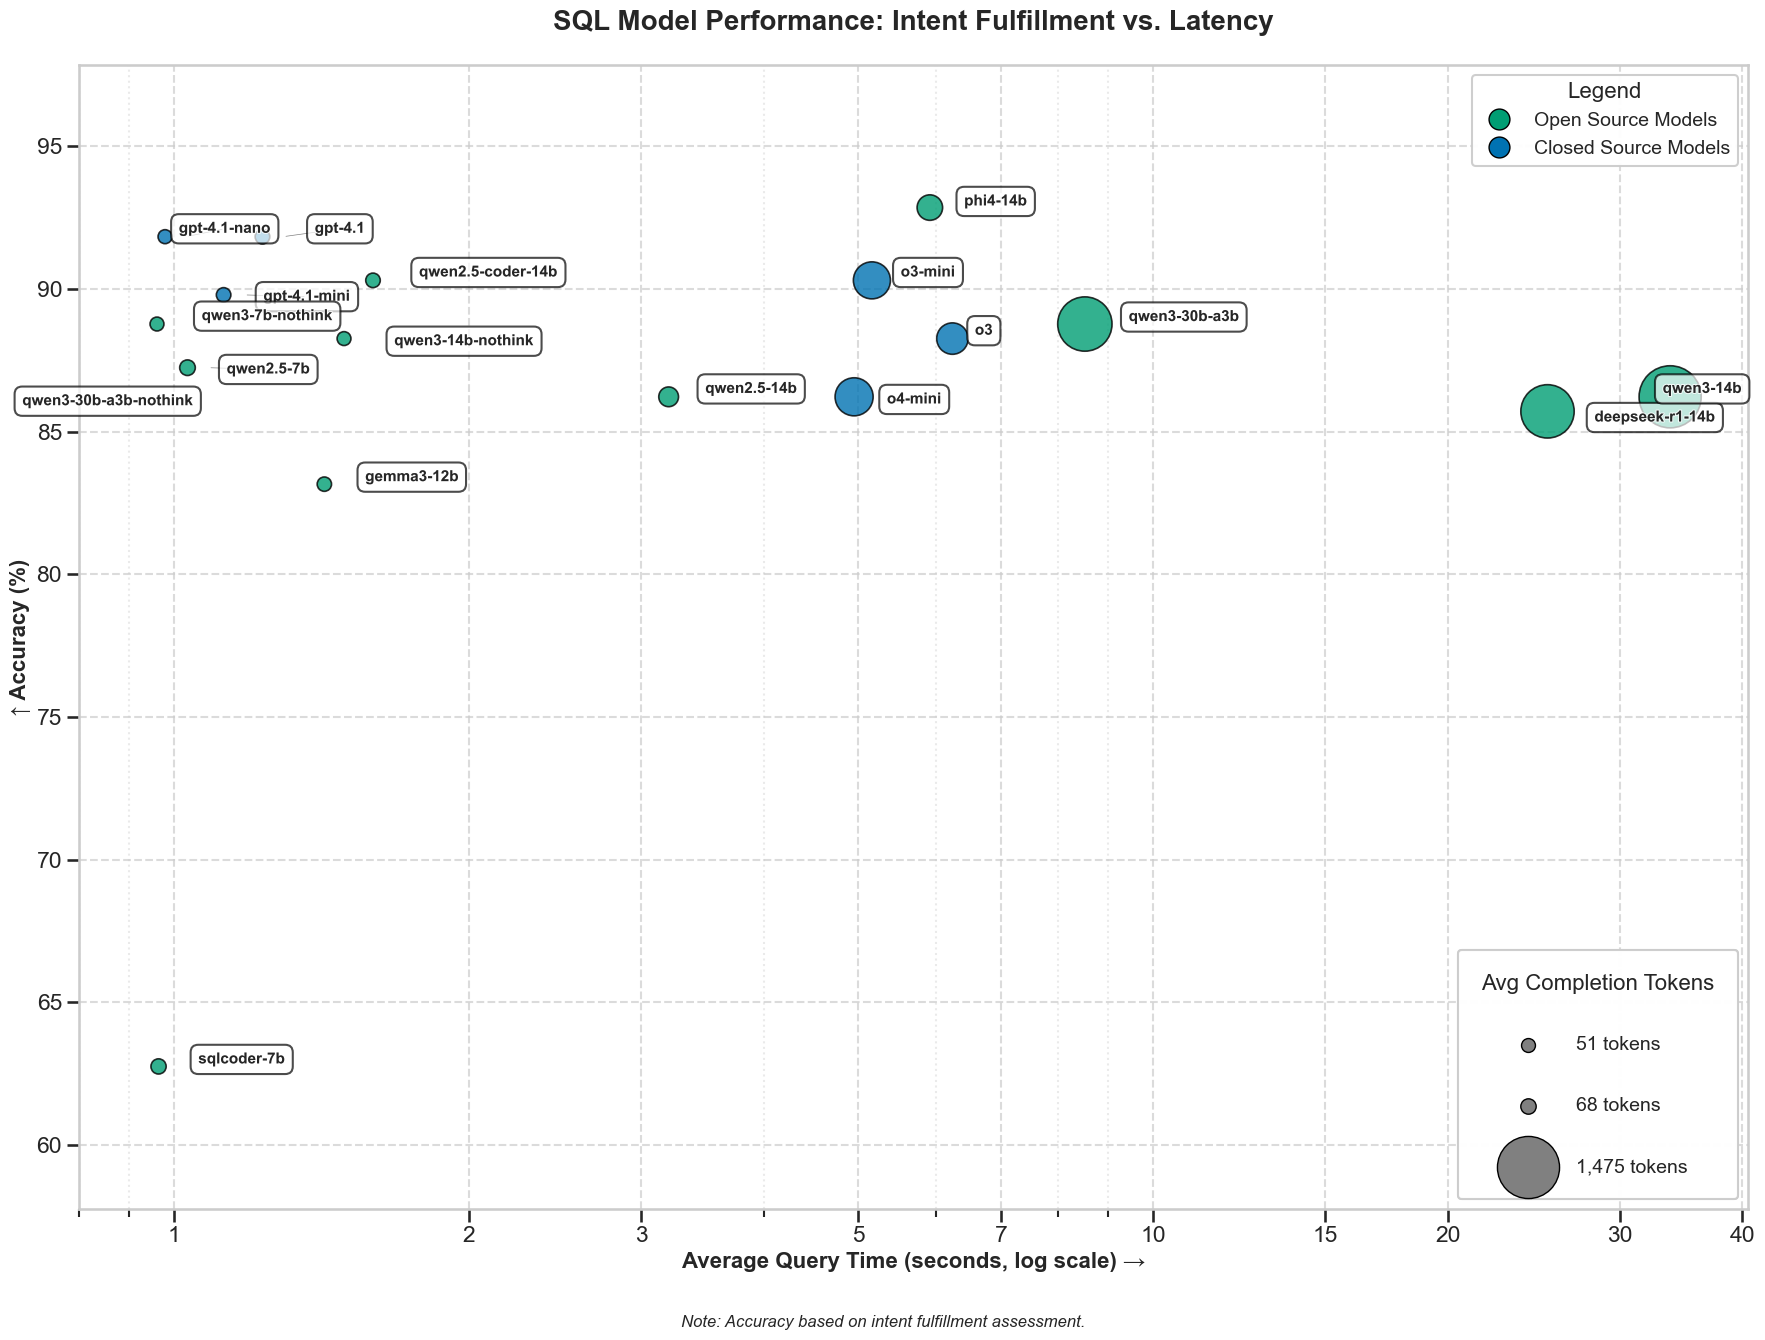

In [21]:
plot_model_comparison(metrics, accuracy_metric='intent',)

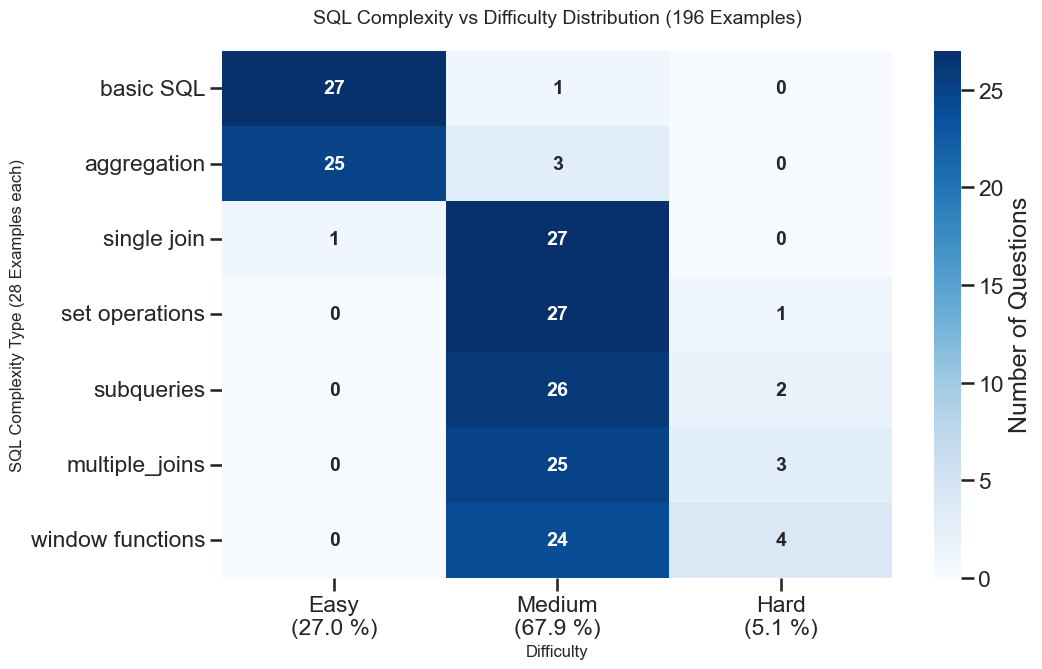

In [15]:
plot_complexity_heatmap(metrics, complexity_map)

0.8928571428571429